#Aprendizaje Automático 2
## TP 2 -Redes Recurrentes
## Problema 1 - Detección de idioma

## Enunciado

En este problema se presenta un conjunto de datos que contiene clips de audio correspondientes a oraciones habladas en distintos idiomas.

**Dataset**

https://www.tensorflow.org/datasets/catalog/xtreme_s


El dataset proporcionado incluye diversos sub-datasets correspondientes a oraciones habladas en distintos idiomas. Utilizaremos un subconjunto de estos datasets para entrenar un clasificador de idiomas hablados.


**Objetivo**

Utilizando el dataset proporcionado, el objetivo es construir dos modelos de clasificación utilizando redes neuronales que puedan inferir el idioma correspondiente.


Se emplearán los siguientes idiomas:


*   Español: https://www.tensorflow.org/datasets/catalog/xtreme_s#xtreme_sfleurses_419
*   Inglés: https://www.tensorflow.org/datasets/catalog/xtreme_s#xtreme_sfleursen_us
*   Francés: https://www.tensorflow.org/datasets/catalog/xtreme_s#xtreme_sfleursfr_fr
*   Japonés: https://www.tensorflow.org/datasets/catalog/xtreme_s#xtreme_sfleursja_jp

Se entrenarán dos modelos de distintas arquitecturas y se compararán los resultados:

* Modelo convolucional sobre los espectrogramas de los clips.
* Modelo recurrente sobre los espectrogramas de los clips.

##Setup

Se importan las librerías y dependencias necesarias, y se fija el valor de la semilla para lograr reproducibilidad.

In [117]:
!pip install -U tensorflow_datasets
!pip install pydub
!apt-get install ffmpeg -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [118]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
from pydub import AudioSegment
import random
import seaborn as sns
import shutil
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import models
from tqdm import tqdm
import wave

In [119]:
# Fijar la semilla
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

Establecer GPU por defecto en caso de estar disponible

In [120]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Carga de Datos

###Funciones

In [121]:
def amplify_audio(audio, target_level=-20.0):
    """
    Amplifica el audio para alcanzar un nivel objetivo de dBFS.

    Parameters:
        audio (AudioSegment): Objeto de audio cargado con pydub.
        target_level (float): Nivel de dBFS objetivo.

    Returns:
        AudioSegment: Audio amplificado.
    """
    change_in_dBFS = target_level - audio.dBFS
    return audio.apply_gain(change_in_dBFS)

def is_silent_or_low(audio, silence_threshold=0.01, low_volume_threshold=-35.0):
    """
    Verifica si el audio es silencioso o tiene un volumen bajo.

    Parameters:
        audio (AudioSegment): Objeto de audio cargado con pydub.
        silence_threshold (float): Variación mínima en los datos para considerarlo no silencioso.
        low_volume_threshold (float): Nivel de dBFS por debajo del cual se considera que el audio tiene un volumen bajo.

    Returns:
        bool: True si el audio es silencioso o de bajo volumen, False en caso contrario.
    """
    samples = np.array(audio.get_array_of_samples())
    is_silent = np.max(samples) - np.min(samples) < silence_threshold
    is_low_volume = audio.dBFS < low_volume_threshold
    return is_silent or is_low_volume

def convert_to_mono(input_dir, output_dir, silence_threshold=0.01, low_volume_threshold=-35.0, target_level=-20.0):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Contar archivos .wav para configurar la barra de progreso
    wav_files = []
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith(".wav"):
                wav_files.append(os.path.join(root, file))

    # Crear barra de progreso
    with tqdm(total=len(wav_files), desc="Procesando archivos", unit="archivo") as pbar:
        for input_path in wav_files:
            # Leer el archivo de audio
            audio = AudioSegment.from_file(input_path)

            # Verificar si el audio es silencioso o de bajo volumen
            if is_silent_or_low(audio, silence_threshold, low_volume_threshold):
                # Amplificar el audio
                audio = amplify_audio(audio, target_level)

            # Determinar la ruta de salida
            output_path = os.path.join(output_dir, os.path.relpath(input_path, input_dir))

            # Crear subdirectorios si no existen
            os.makedirs(os.path.dirname(output_path), exist_ok=True)

            # Convertir a mono si no lo está
            if audio.channels != 1:
                audio = audio.set_channels(1)

            # Exportar en formato PCM
            audio.export(output_path, format="wav", parameters=["-ar", "16000"])

            # Actualizar barra de progreso
            pbar.update(1)

In [122]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

###Desarrollo

In [123]:
# Se cargan los datos de un link de Drive
!gdown --id 1isbsqKD1Al_I-39rqzIi_pGCLb89MEtx -O dataset_reducido.zip
!unzip dataset_reducido.zip -d ./dataset_reducido
data_dir = "./dataset_reducido"

# Se ajusta el audio y se convierte a monofónico
convert_to_mono(data_dir, data_dir)

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1isbsqKD1Al_I-39rqzIi_pGCLb89MEtx
From (redirected): https://drive.google.com/uc?id=1isbsqKD1Al_I-39rqzIi_pGCLb89MEtx&confirm=t&uuid=cbf8572a-b52c-4245-82c8-b626ea7a59a5
To: /content/dataset_reducido.zip
100% 427M/427M [00:09<00:00, 44.3MB/s]
Archive:  dataset_reducido.zip
replace ./dataset_reducido/español/1001744349579669536.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Procesando archivos:   0%|          | 0/800 [00:00<?, ?archivo/s]<ipython-input-121-eae8a36cacec>:28: RuntimeWarning: overflow encountered in scalar subtract
  is_silent = np.max(samples) - np.min(samples) < silence_threshold
Procesando archivos:   0%|          | 4/800 [00:01<03:40,  3.61archivo/s]<ipython-input-121-eae8a36cacec>:28: RuntimeWarning: overflow encountered in scalar subtract
  is_silent = np.max(samples) - np.min(samples) < silence_threshold
Procesando archivos:   1%|          | 5/800 [00:01<03:26,  3.85archivo/s]<ipython-input-121-eae8a36cacec>:28: RuntimeWarning: overflow encountered in scalar subtract
  is_silent = np.max(samples) - np.min(samples) < silence_threshold
Procesando archivos:   1%|          | 7/800 [00:01<02:58,  4.44archivo/s]<ipython-input-121-eae8a36cacec>:28: RuntimeWarning: overflow encountered in scalar subtract
  is_silent = np.max(samples) - np.min(samples) < silence_threshold
Procesando archivos:   1%|▏         | 10/800 [00:02<02:43,  4.84archivo/

Se cuentan los archivos de audio por clase, observándose que el dataset está equilibrado.

In [124]:
class_counts = {}
for class_name in sorted(os.listdir(data_dir)):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        num_files = len([f for f in os.listdir(class_path) if f.endswith(".wav")])
        class_counts[class_name] = num_files

for class_name, count in class_counts.items():
    print(f"Clase '{class_name}': {count} archivos")

# Total de archivos
total_files = sum(class_counts.values())
print(f"Total de archivos: {total_files}")

Clase 'español': 200 archivos
Clase 'frances': 200 archivos
Clase 'ingles': 200 archivos
Clase 'japones': 200 archivos
Total de archivos: 800


##Hiperparámetros CNN

In [125]:
N=8               #cantidad de segundos adoptada para homogeneizar los archivos de audio

#Hiperparámetros para entrenar la red CNN
BATCH_SIZE = 32   #tamaño del lote
IMAGE_SIZE = 128  #tamaño de la imagen
FM_CL_1 = 16      #cantidad de filtros de la primera capa convolucional
FM_CL_2 = 32      #cantidad de filtros de la segunda capa convolucional
DRP_1 = 0.5       #dropout a la salida de la segunda capa convolucional
FC_1 = 128        #cantidad de neuronas de la primera capa densa
DRP_2 = 0.5       #dropout a la salida de la primera capa densa

##Separación de datos en train y validation

Se ajustan los siguientes hiperparámetros para el diseño de la red.

In [126]:
# Se carga el dataset desde el directorio
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # Porcentaje de validación
    seed=SEED,
    output_sequence_length=N*16000,  # Duración fija de n segundos (output_sequence_length=n*16kHz)
    subset="both"  # Entrenamiento y validación
)

Found 800 files belonging to 4 classes.
Using 640 files for training.
Using 160 files for validation.


In [127]:
# Obtener los nombres de las etiquetas
label_names = np.array(train_ds.class_names)

In [128]:
train_ds.element_spec

(TensorSpec(shape=(None, 128000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [129]:
# El dataset contiene un solo canal de audio por clip, se usa `tf.squeeze` para descartar el eje extra.
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [130]:
# Se chequea la eliminación del eje extra
train_ds.element_spec

(TensorSpec(shape=(None, 128000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [131]:
# Se chequea la forma de los datos de audio y sus etiquetas en un batch del dataset de entrenamiento
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(32, 128000)
(32,)


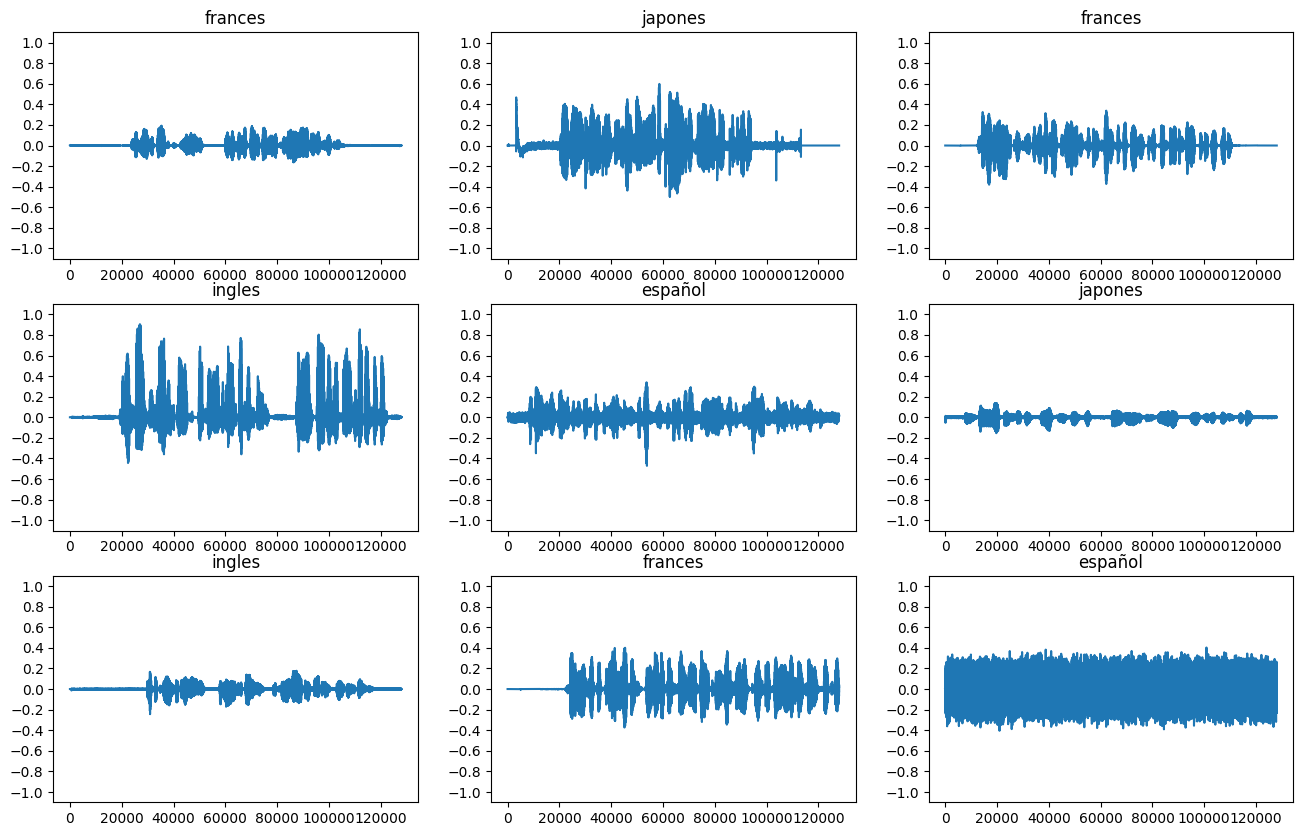

In [132]:
# Se plotean algunos archivos de audio ya procesados
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Conversión de formas de onda a espectrogramas


###Funciones

In [133]:
def get_spectrogram(waveform, frame_length=255, frame_step=128):
    """
    Convierte una forma de onda (waveform) en un espectrograma utilizando las siguientes operaciones:
    - Aplica la STFT (Short-Time Fourier Transform) para convertir la señal en frecuencia y tiempo.
    - Calcula la magnitud del STFT.
    - Agrega una dimensión de `canales` para que el espectrograma sea compatible con entradas de capas convolucionales
      (forma esperada: `batch_size`, `height`, `width`, `channels`).

    Args:
        waveform: Tensor que representa la señal de audio en formato de onda.
        frame_length: Longitud de cada ventana para la STFT.
        frame_step: Paso entre ventanas consecutivas.

    Returns:
        spectrogram: Espectrograma con una dimensión de canales añadida.
    """
    # Aplica la STFT (Short-Time Fourier Transform).
    spectrogram = tf.signal.stft(waveform, frame_length, frame_step)

    # Calcula la magnitud del STFT.
    spectrogram = tf.abs(spectrogram)

    # Agrega una dimensión de `canales`.
    spectrogram = spectrogram[..., tf.newaxis]

    return spectrogram


In [134]:
def plot_spectrogram(spectrogram, ax):
    """
    Genera un gráfico del espectrograma utilizando una escala logarítmica para las frecuencias.
    - Si el espectrograma tiene múltiples dimensiones, lo aplana para que sea compatible con el gráfico.
    - Convierte las frecuencias a escala logarítmica y transpone el espectrograma, de forma que el tiempo
      esté representado en el eje x (columnas).
    - Agrega un epsilon para evitar tomar el logaritmo de cero.

    Args:
        spectrogram: Espectrograma en formato de matriz (puede incluir una dimensión de canales).
        ax: Eje de matplotlib donde se generará el gráfico.

    Returns:
        No retorna nada, pero dibuja el espectrograma en el eje proporcionado.
    """
    # Si el espectrograma tiene más de dos dimensiones, se aplana.
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)

    # Convierte las frecuencias a escala logarítmica y transpone el espectrograma.
    # Se agrega un epsilon para evitar logaritmo de cero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)

    # Obtiene dimensiones del espectrograma.
    height = log_spec.shape[0]
    width = log_spec.shape[1]

    # Configura los ejes X (tiempo) e Y (frecuencia).
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)

    # Dibuja el espectrograma en el eje proporcionado.
    ax.pcolormesh(X, Y, log_spec)

In [135]:
def make_spec_ds(ds):
    """
    Convierte un conjunto de datos (dataset) de audio en espectrogramas.

    - Para cada clip de audio en el dataset, calcula el espectrograma utilizando la función `get_spectrogram`.
    - Conserva las etiquetas originales asociadas a cada clip de audio.
    - Usa procesamiento en paralelo para optimizar la velocidad.

    Args:
        ds: Conjunto de datos de TensorFlow (tf.data.Dataset) que contiene clips de audio y sus etiquetas.

    Returns:
        Un nuevo conjunto de datos (tf.data.Dataset) donde cada entrada consiste en un espectrograma
        y su etiqueta correspondiente.
    """
    # Aplica `get_spectrogram` a cada clip de audio en el dataset, conservando las etiquetas.
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE  # Optimiza la ejecución usando múltiples núcleos.
    )

###Desarrollo

In [136]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: frances
Waveform shape: (128000,)
Spectrogram shape: (999, 129, 1)
Audio playback


Label: japones
Waveform shape: (128000,)
Spectrogram shape: (999, 129, 1)
Audio playback


Label: frances
Waveform shape: (128000,)
Spectrogram shape: (999, 129, 1)
Audio playback


Se plotean formas de onda y sus respectivos espectrogramas.

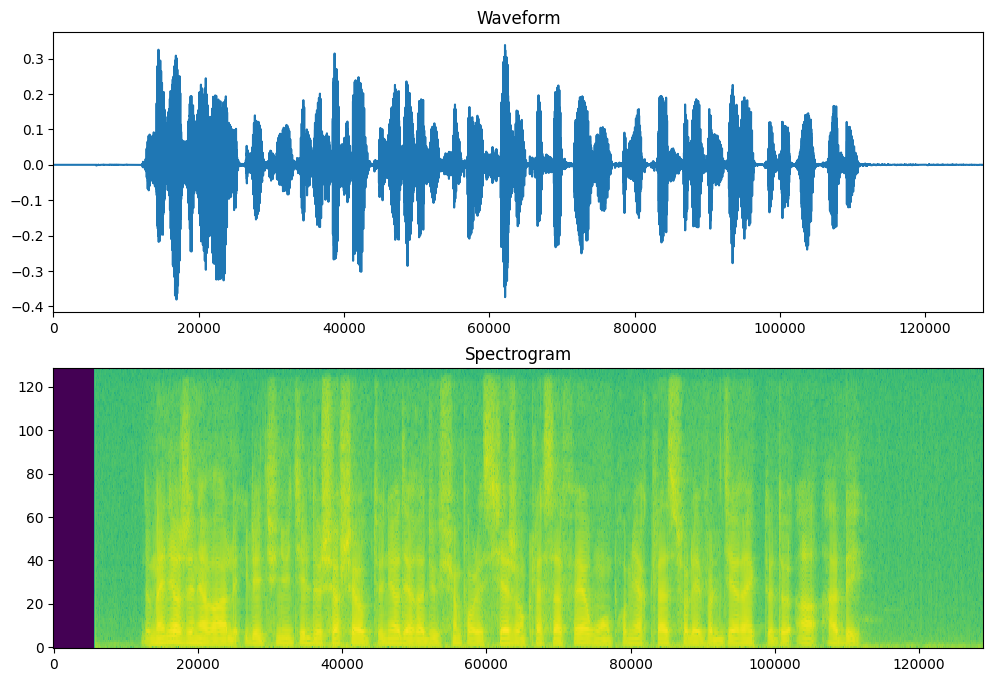

In [137]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, N*16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Se cre un dataset de espectrogramas utilizando la función definida.

In [138]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

Se examinan los espectrogramas para distintos ejemplos del dataset.

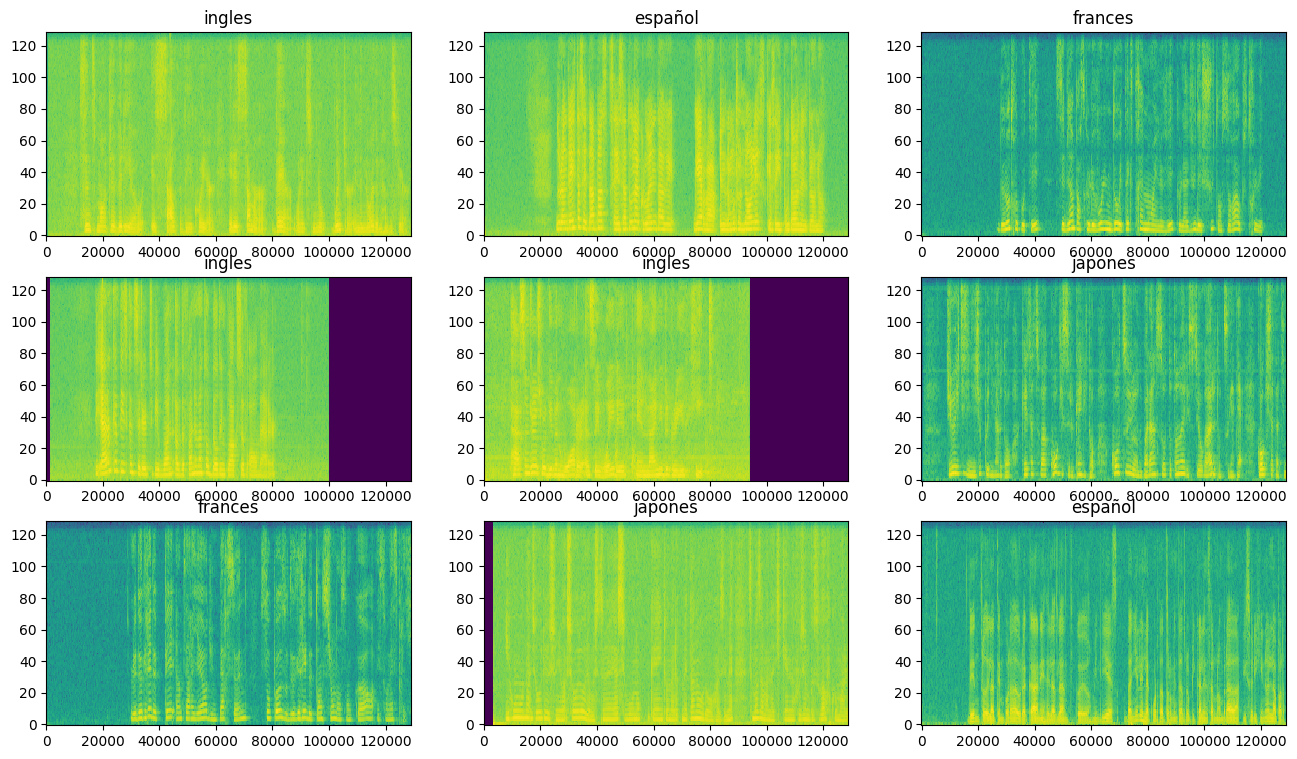

In [139]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

##Diseño de la CNN

###Funciones

In [140]:
def select_random_wav(base_dir):
    """
    Selecciona aleatoriamente un archivo WAV de cualquier carpeta de idiomas.

    Parameters:
        base_dir (str): Directorio base donde están las carpetas de idiomas.

    Returns:
        tuple: Ruta completa del archivo seleccionado, idioma al que pertenece.
    """
    # Listar carpetas de idiomas
    languages = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    # Elegir una carpeta e idioma aleatoriamente
    chosen_language = random.choice(languages)
    language_dir = os.path.join(base_dir, chosen_language)

    # Listar archivos WAV en la carpeta
    wav_files = [f for f in os.listdir(language_dir) if f.endswith(".wav")]

    # Elegir un archivo WAV aleatorio
    chosen_file = random.choice(wav_files)
    chosen_file_path = os.path.join(language_dir, chosen_file)

    return chosen_file_path, chosen_language

###Desarrollo

Para el modelo, se utilizará una red neuronal convolucional simple (CNN), a partir de las imágenes de espectrogramas generadas de los archivos de audio.

In [141]:
#Se optimiza la carga del dataset
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

#Se define la arquitectura del modelo
model_cnn = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    norm_layer,
    layers.Conv2D(FM_CL_1, 3, activation='relu'),
    layers.Conv2D(FM_CL_2, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(DRP_1),
    layers.Flatten(),
    layers.Dense(FC_1, activation='relu'),
    layers.Dropout(DRP_2),
    layers.Dense(num_labels),
])

#Se compila el modelo
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model_cnn.summary()

Input shape: (999, 129, 1)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)                │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_1 (Normalization)      │ (None, 128, 128, 1)         │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 124, 124, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 123008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │      15,745,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,750,471 (60.08 MB)

 Trainable params: 15,750,468 (60.08 MB)

 Non-trainable params: 3 (16.00 B)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2783 - loss: 2.9503 - val_accuracy: 0.5875 - val_loss: 1.1545
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5436 - loss: 1.0929 - val_accuracy: 0.5938 - val_loss: 0.9963
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6482 - loss: 0.8594 - val_accuracy: 0.7250 - val_loss: 0.8306
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7945 - loss: 0.6155 - val_accuracy: 0.7688 - val_loss: 0.7116
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8479 - loss: 0.4435 - val_accuracy: 0.7812 - val_loss: 0.7035
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9038 - loss: 0.3303 - val_accuracy: 0.7750 - val_loss: 0.6966
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9350 - loss: 0.2153 - val_accuracy: 0.7500 - val_loss: 0.6948
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9392 - loss: 0.1899 - val_accuracy: 0.7563 - val_loss:

Text(0, 0.5, 'Accuracy [%]')

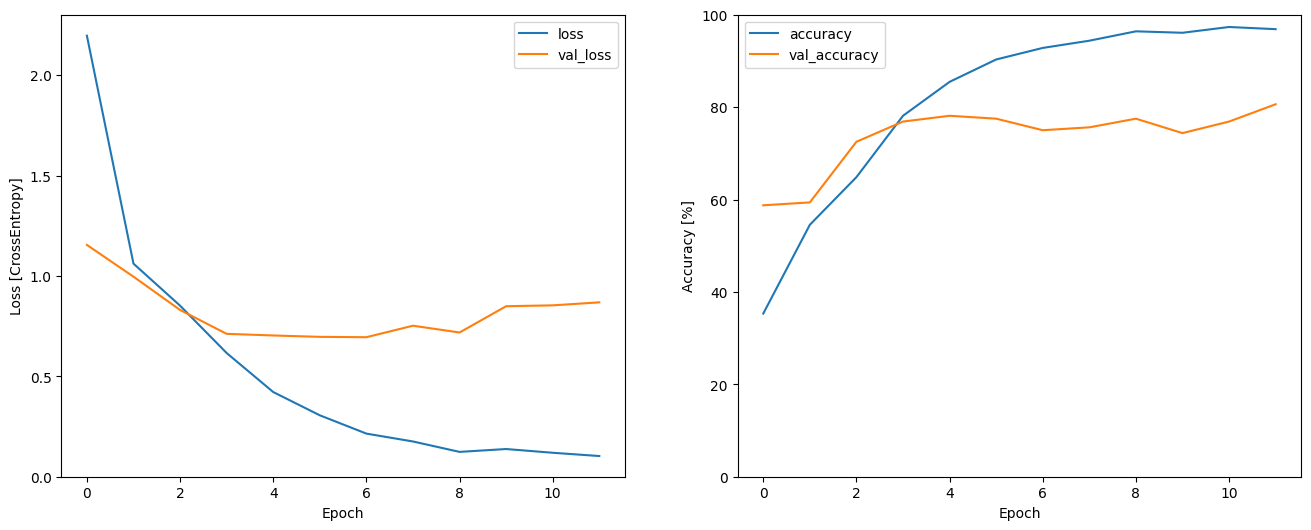

In [142]:
EPOCHS = 50
history_cnn = model_cnn.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5,restore_best_weights=True),
)

# Obtener el índice de la mejor época restaurada
best_epoch_index = history_cnn.history['val_loss'].index(min(history_cnn.history['val_loss']))

# Mostrar las métricas de la mejor época
print(f"Mejor Época Restaurada: {best_epoch_index + 1}")
print(f"Entrenamiento - Loss: {history_cnn.history['loss'][best_epoch_index]:.4f}, Accuracy: {history_cnn.history['accuracy'][best_epoch_index]:.4f}")
print(f"Validación - Loss: {history_cnn.history['val_loss'][best_epoch_index]:.4f}, Accuracy: {history_cnn.history['val_accuracy'][best_epoch_index]:.4f}")

#Ploteamos los resultados
metrics = history_cnn.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history_cnn.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history_cnn.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

La pérdida (loss) disminuye consistentemente con el aumento de las épocas, lo que indica que el modelo está aprendiendo durante el entrenamiento.
La pérdida de validación (val_loss) también disminuye al principio, pero se estabiliza y comienza a fluctuar a partir de la épooca 6, indicando un posible sobreajuste, ya que la pérdida de validación deja de mejorar mientras que la de entrenamiento sigue disminuyendo.

La precisión de entrenamiento (accuracy) sigue aumentando con cada época, alcanzando un valor alto del 96.7%.
La precisión de validación (val_accuracy) aumenta inicialmente, pero se estabiliza y muestra fluctuaciones alrededor del 78.75%.

El modelo logra un buen rendimiento en los datos de entrenamiento, pero no generaliza perfectamente en los datos de validación, sugiriendo un leve sobreajuste.

Época Restaurada:
La mejor época restaurada fue la época 9, con las siguientes métricas:
Entrenamiento:
Pérdida: 0.1337
Precisión: 96.7%
Validación:
Pérdida: 0.6467
Precisión: 78.75%

In [143]:
# Guardar el modelo como un archivo HDF5
model_cnn.save("model_cnn.h5")

###Matriz de confusión

Se utiliza una matriz de confusión para verificar qué tan bien clasificó el modelo cada uno de los idiomas en el conjunto de validación:

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


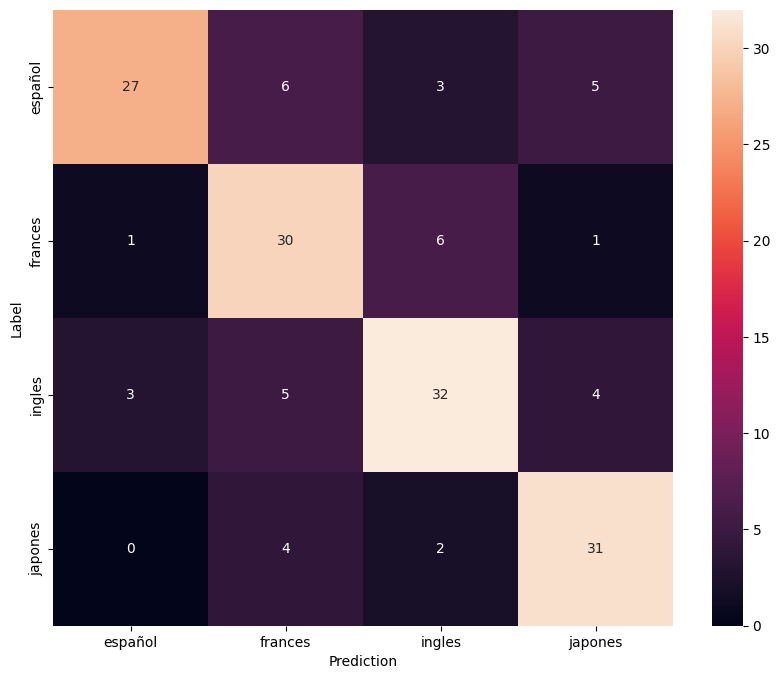

In [144]:
y_pred = model_cnn.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

La diagonal principal muestra que el modelo predice correctamente la mayoría de las muestras para cada idioma.

Francés-Inglés y Japonés-Francés tienen mayores tasas de confusión, lo que sugiere que las características aprendidas por el modelo no son suficientemente discriminativas para estas combinaciones.

###Predicción de audio

Se realiza una comprobación aleatoria de clasificación sobre el dataset original.

In [145]:
file_path, language = select_random_wav(data_dir)
x = tf.io.read_file(str(file_path))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=N*16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

y_pred = model_cnn.predict(x)
predicted_class_index = tf.argmax(y_pred, axis=1).numpy()[0]
predicted_class_label = label_names[predicted_class_index]

print('Label:', predicted_class_label)
display.display(display.Audio(waveform, rate=16000))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Label: ingles


##Diseño de la RNN

Se diseña una red recurrente para la clasificación de audio.

###Funciones

In [146]:
def preprocess_rnn_data(spectrogram, label):
    """
    Preprocesa los datos para su uso en una red recurrente (RNN).

    Este preprocesamiento incluye la eliminación de dimensiones redundantes,
    submuestreo temporal para reducir la longitud de las secuencias, y la
    normalización de los valores para mejorar el rendimiento del modelo.

    Args:
        spectrogram (tf.Tensor): Tensor del espectrograma con forma
                                 (batch, tiempo, características, canal).
                                 Normalmente, el canal es redundante y tiene un valor de 1.
        label (tf.Tensor): Etiqueta asociada a cada espectrograma, sin modificaciones.

    Returns:
        Tuple[tf.Tensor, tf.Tensor]:
            - spectrogram: Tensor preprocesado con forma (batch, 500, características).
              Los valores están normalizados (media 0, desviación estándar 1).
            - label: Etiqueta correspondiente al espectrograma, sin cambios.
    """
    # Eliminar la dimensión del canal redundante
    spectrogram = tf.squeeze(spectrogram, axis=-1)  # De (batch, 999, 129, 1) a (batch, 999, 129)

    # Submuestreo temporal: Mantener solo las primeras 500 secuencias
    spectrogram = spectrogram[:, :500, :]

    # Normalización del espectrograma
    mean = tf.reduce_mean(spectrogram)
    std = tf.math.reduce_std(spectrogram)
    spectrogram = (spectrogram - mean) / std

    return spectrogram, label

###Desarrollo

In [147]:
for spec, _ in train_spectrogram_ds.take(1):
    print(f"Forma del espectrograma: {spec.shape}")

Forma del espectrograma: (32, 999, 129, 1)


In [148]:
train_rnn_ds = train_spectrogram_ds.map(preprocess_rnn_data, num_parallel_calls=tf.data.AUTOTUNE)
val_rnn_ds = val_spectrogram_ds.map(preprocess_rnn_data, num_parallel_calls=tf.data.AUTOTUNE)

In [149]:
# Definición del modelo
model_rnn = models.Sequential([
    layers.Input(shape=(500, 129)),  # Forma: (timesteps, features)

    # Primera capa recurrente
    layers.LSTM(256, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),

    # Segunda capa recurrente
    layers.LSTM(128, dropout=0.1, recurrent_dropout=0.1),

    # Capa densa
    layers.Dense(64, activation='relu'),

    # Regularización
    layers.Dropout(0.5),

    # Capa de salida
    layers.Dense(num_labels, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

# Compilar el modelo
model_rnn.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model_rnn.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 500, 256)            │         395,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 600,900 (2.29 MB)

 Trainable params: 600,900 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.2702 - loss: 1.3796 - val_accuracy: 0.3812 - val_loss: 1.2872
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.3827 - loss: 1.2724 - val_accuracy: 0.4187 - val_loss: 1.2276
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.4172 - loss: 1.1953 - val_accuracy: 0.4750 - val_loss: 1.1401
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.4928 - loss: 1.1420 - val_accuracy: 0.5750 - val_loss: 1.1123
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.5226 - loss: 1.0860 - val_accuracy: 0.5250 - val_loss: 1.0901
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.5175 - loss: 1.0284 - val_accuracy: 0.5562 - val_loss: 1.1135
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.5534 - loss: 1.0518 - val_accuracy: 0.5938 - val_loss: 1.0312
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.5710 - loss: 0.9988 - val_accuracy: 0.5500 - val_loss

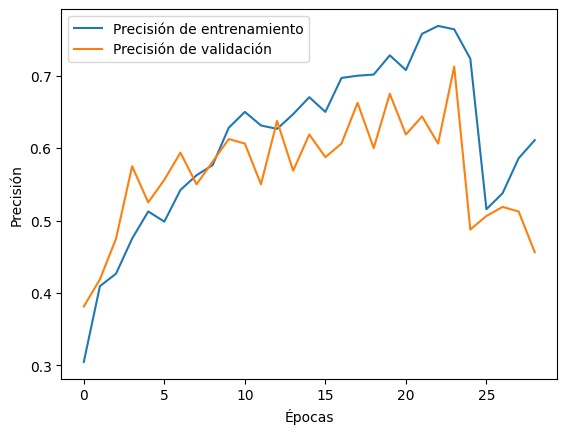

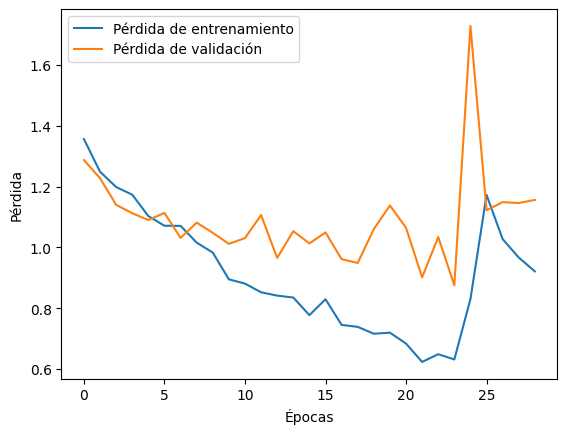

In [150]:
history_rnn = model_rnn.fit(
    train_rnn_ds,
    validation_data=val_rnn_ds,
    epochs= EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5,restore_best_weights=True)
)

# Obtener el índice de la mejor época restaurada
best_epoch_index = history_rnn.history['val_loss'].index(min(history_rnn.history['val_loss']))

# Mostrar las métricas de la mejor época
print(f"Mejor Época Restaurada: {best_epoch_index + 1}")
print(f"Entrenamiento - Loss: {history_rnn.history['loss'][best_epoch_index]:.4f}, Accuracy: {history_rnn.history['accuracy'][best_epoch_index]:.4f}")
print(f"Validación - Loss: {history_rnn.history['val_loss'][best_epoch_index]:.4f}, Accuracy: {history_rnn.history['val_accuracy'][best_epoch_index]:.4f}")

# Precisión
plt.plot(history_rnn.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history_rnn.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Pérdida
plt.plot(history_rnn.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history_rnn.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

La pérdida (loss) disminuye consistentemente con el aumento de las épocas, lo que indica que el modelo está aprendiendo durante el entrenamiento.
La pérdida de validación (val_loss) también disminuye al principio, pero se estabiliza y comienza a fluctuar a partir de la épooca 13, indicando un posible sobreajuste, ya que la pérdida de validación deja de mejorar mientras que la de entrenamiento sigue disminuyendo.

La precisión de entrenamiento (accuracy) sigue aumentando con cada época, alcanzando un valor máximo del 70.3%.
La precisión de validación (val_accuracy) también mejora inicialmente, alcanzando un valor máximo del 64.38% en la mejor época, con una estabilización sobre la época 13 para luego aumentar hasta el valor ma´ximo.

El modelo logra un rendimiento razonable en los datos de entrenamiento, con un leve sobreajuste en los datos de validación.


El modelo restauró los pesos de la mejor época, la época 13, con las siguientes métricas:

Entrenamiento:
*   Pérdida (loss): 0.8143
*   Precisión (accuracy): 66.87%

Validación:
*   Pérdida (val_loss): 0.9321
*   Precisión (val_accuracy): 64.38%

In [151]:
# Se guarda el modelo como un archivo HDF5
model_rnn.save("model_rnn.h5")

###Matriz de confusión

Se utiliza una matriz de confusión para verificar qué tan bien clasificó el modelo cada uno de los idiomas en el conjunto de validación:

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


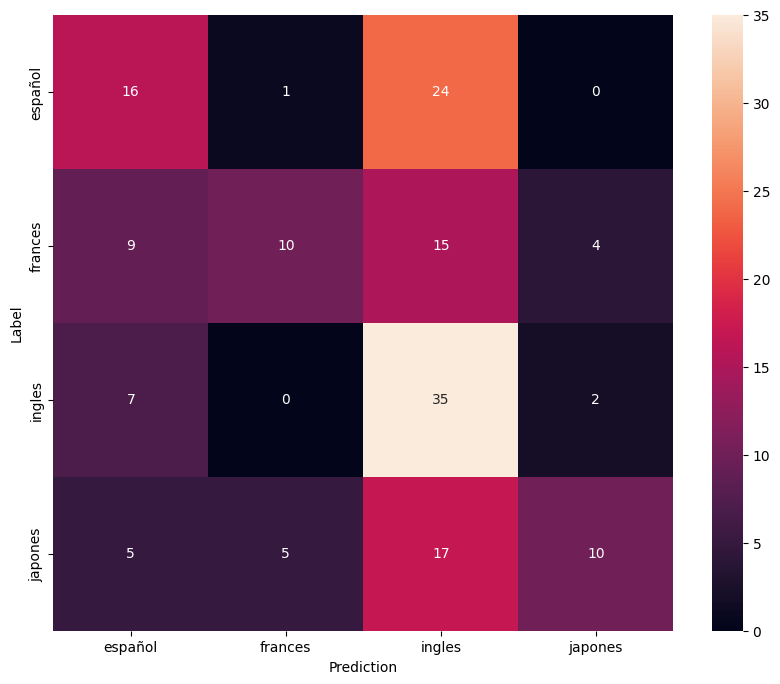

In [152]:
y_pred_rnn = model_rnn.predict(val_spectrogram_ds)
y_pred_rnn = tf.argmax(y_pred_rnn, axis=1)
y_true_rnn = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true_rnn, y_pred_rnn)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

La diagonal principal de la matriz muestra que el modelo predice correctamente una proporción significativa de muestras para cada idioma, indicando que el modelo tiene un desempeño razonable en general.

Las mayores confusiones ocurren en las siguientes combinaciones idioma-predicción:

*   Español-Inglés
*   Francés-Español
*   Inglés-Español
*   Japonés-Inglés

###Predicción de audio

Se realiza una comprobación aleatoria de clasificación sobre el dataset original.

In [153]:
file_path, language = select_random_wav(data_dir)
x = tf.io.read_file(str(file_path))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=N*16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[:, :500, :]
mean = tf.reduce_mean(x)
std = tf.math.reduce_std(x)
x = (x - mean) / std
x = x[tf.newaxis,...]

y_pred = model_rnn.predict(x)
# Obtener el índice de la clase con mayor probabilidad
predicted_class_index = tf.argmax(y_pred, axis=1).numpy()[0]
# Obtener el nombre de la clase correspondiente
predicted_class_label = label_names[predicted_class_index]

print('Label:', predicted_class_label)
display.display(display.Audio(waveform, rate=16000))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Label: japones


## Conclusiones

Se muestran a continuación dos tablas con el resumen de las redes evaluadas.

**Tabla 1- Modelos entrenados para CNN**

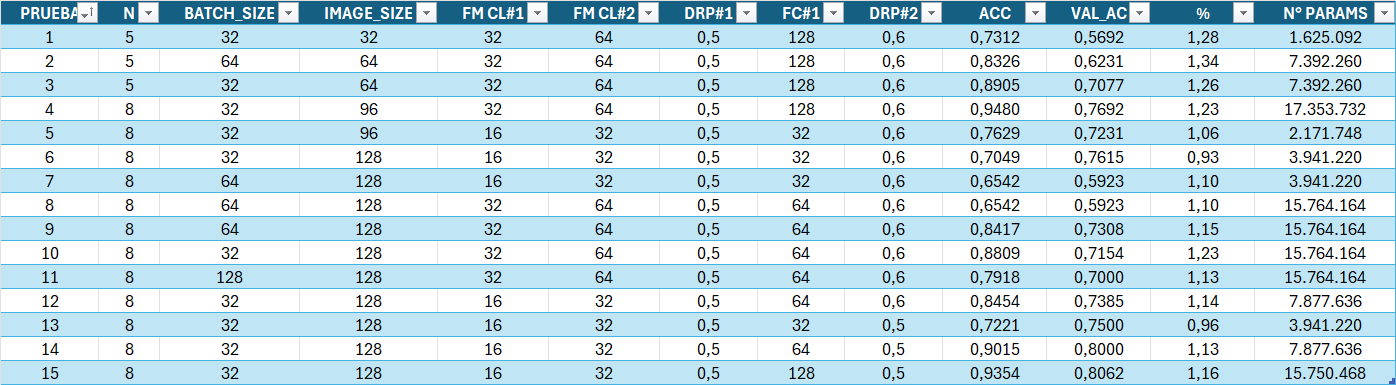

**Tabla 2- Modelos entrenados para RNN**

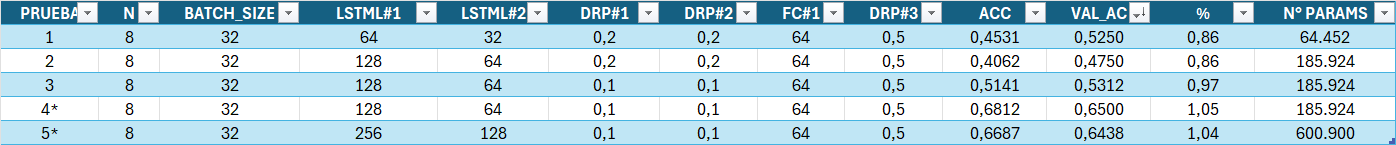

*   ACC: valor de accuracy en train para la mejor época.
*   VAL_ACC: valor de accuracy en validation para la mejor época.
*   %: porcentaje de sobreajuste.

(**) para las pruebas 4 y 5  se redujo la cantidad de vectores de 999 a 500, mejorando las métricas y permitiendo aumentar la red al mejorar tiempo de ejecución. *texto en cursiva*



---



Luego de la evaluación de las dos arquitecturas planteadas (CNN y RNN) y con diferentes configuraciones de hiperparámetros, se ha observado que la red CNN ha sido la que mejor desempeño obtuvo.

Si bien la red CNN tiene más parámetros entrenables (alrededor de un orden de magnitud más que las RNN), su tiempo de entrenamiento fue de alrededor de la mitad, por lo que resultaron más eficientes.

Se observa que los modelos entrenados en RNN resultaron más estables al sobreajuste que los de CNN. La falta de capacidad de cómputo suficiente impidió seguir entrenando modelos con mayor cantidad de parámetros en RNN.

Otro punto importante a recalcar es lo acotado del dataset, tanto en cantidad de muestras como en cantidad de segundos por muestra.



---


Un dato curioso es la presencia de archivos de audio con muy bajo volumen. Inicialmente se eliminaron, reduciendo el dataset en un 20%.

Luego de varias pruebas se observó que conservar estas pistas de audio permitía conseguir mejores métricas, por lo que se decidió conservarlos.

En todos los casos se aummentó la amplitud para mejorar los espectrogramas generados posteriormente.

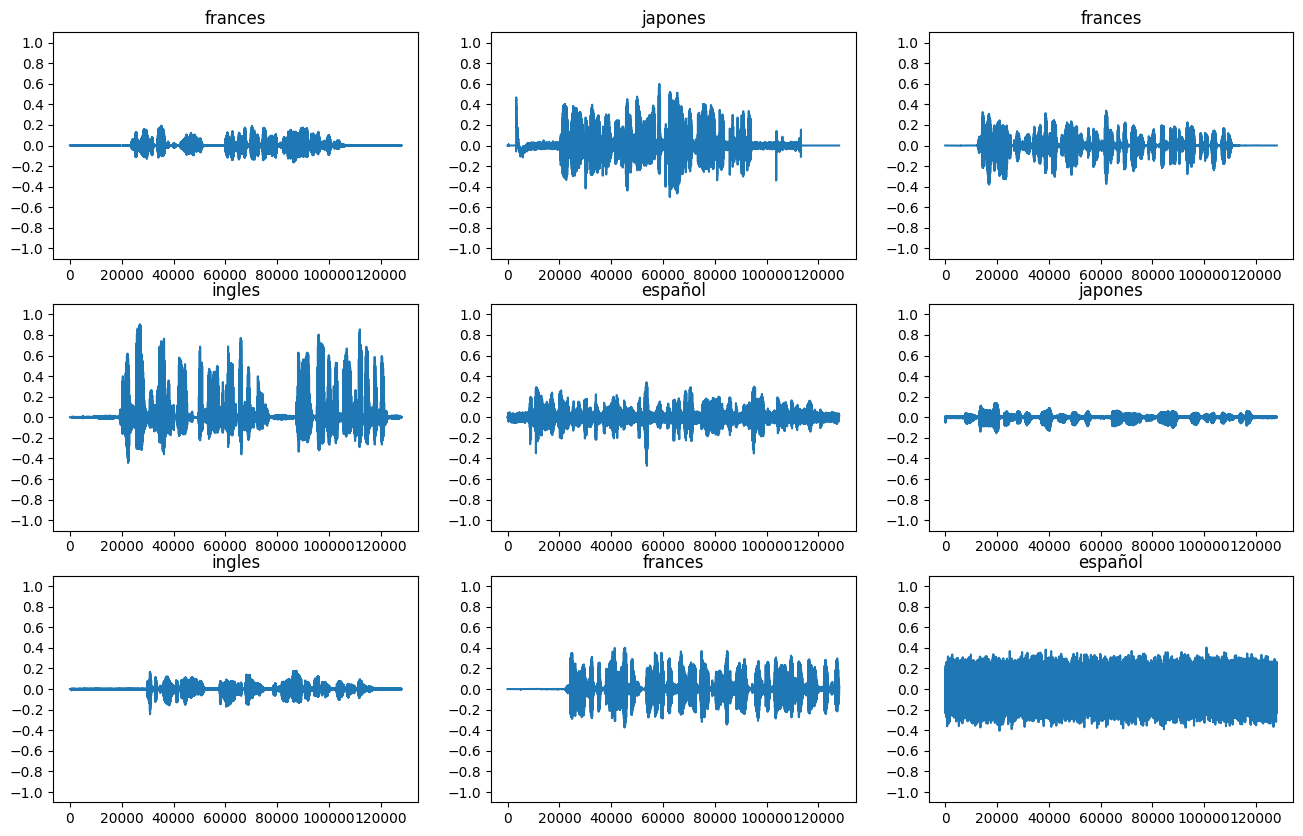



---



Como resuumen se concluye que la red CNN ha sido la mejor en cuanto a métricas y eficiencia, pero tanto en CNN como en RNN queda margen por mejorar si se cuenta con una mayor capacidad de procesamiento para entrenar redes más grandes y/o se cuenta con un dataset más amplio.